In [2]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [10]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 2

# baseline: 
# exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
#            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
# exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])


exp_mc005_brier = {3: "20180428_09_11_35_dcnn_mc_f3p005_brier_150KE_lr2e02",
                   2: "20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02",
                   1: "20180426_14_45_50_dcnn_mc_f1p005_brier_150KE_lr2e02",
                   0: "20180418_15_02_36_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_brier_path = os.path.join(LOG_DIR, exp_mc005_brier[TEST_FOLD])


exp_mc01_brier_results = {0: "test_results_25imgs_fold0_04_19_17_27.dll",
                          1: "",
                          2: "",
                          3: ""}
# 20180508_11_47_05_dcnn_mc_f2p01_brier_20KE_lr2e02
# 20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02
exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])



## Load experimental data and test data set

In [11]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_mc005_brier = ExperimentHandler.load_experiment(exp_mc005_brier_path)
exper_hdl_mc005_brier = ExperimentHandler(exper_mc005_brier, use_logfile=False)
exper_hdl_mc005_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc005_brier.set_model_name("MC-dropout-brier fold-{} (p={})".format(
                                     exper_hdl_mc005_brier.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_brier.exper.model_name))


exper_mc01_brier = ExperimentHandler.load_experiment(exp_mc01_brier_path)
exper_hdl_mc01_brier = ExperimentHandler(exper_mc01_brier, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_brier.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc005_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

  0%|          | 0/25 [00:00<?, ?it/s]

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 2
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02/stats/exper_stats.dll
Model name MC-dropout-brier fold-2 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name MC-dropout brier fold-2 (p=0.1)
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold2/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:01<00:00, 13.77it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Run model evaluation of test set

In [14]:
mc_samples = 10
sample_weights = True
store_details = True
image_range =  [0] # [0, 9, 22] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = False
# if not sample_weights & save_pred_labels => we save pred_labels & referred_pred_labels
save_pred_labels = False

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)


    
print("Ready")

Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-2 (p=0.1) - runID 1
INFO - Running test on 1 images with model from checkpoint 150000
Image 1-patient006 - test loss -2.420  dice(RV/Myo/LV):	ES 0.81/0.80/0.95	ED 0.85/0.78/0.95
					Hausdorff(RV/Myo/LV):	ES 20.10/13.13/10.00	ED 22.79/23.09/12.21
------------------------------------------------------------------------------------------------
Overall:	dice(RV/Myo/LV): ES 0.81 (0.00)/0.80 (0.00)/0.95 (0.00)	ED 0.85 (0.00)/0.78 (0.00)/0.95 (0.00)
Hausdorff(RV/Myo/LV):	ES 20.10 (0.00)/13.13 (0.00)/10.00 (0.00)	ED 22.79 (0.00)/23.09 (0.00)/12.21 (0.00)
INFO - generating statistics for 1 run(s). May take a while
Ready


In [12]:
exper_handler.create_filtered_umaps(u_threshold=0.14)

In [33]:
mc_samples = 10
sample_weights = True
store_details = True
image_range = [0] # [9] # [10, 24] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = True
referral_threshold = 0.12
ref_positives_only = True
save_pred_labels = True

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)



print("Ready")

WARNING - Using uncertainty maps to refer pixels. Threshold 0.12
Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-2 (p=0.1) - runID 1
INFO - Running test on 1 images with model from checkpoint 150000
Ref% ES/ED 51.01/48.14 - #Errors before/after reduction ES: 8999.0/3803.0 ED: 10152.0/5447.0
Image 1-patient006 - test loss -2.528  dice(RV/Myo/LV):	ES 0.81/0.80/0.95	ED 0.84/0.78/0.95
					 After referral		ES 0.94/0.90/0.96	ED 0.92/0.86/0.97
					Hausdorff(RV/Myo/LV):	ES 20.10/14.00/10.00	ED 22.79/17.03/11.63
					After referral:		ES 11.29/10.48/8.85	ED 22.79/15.96/11.63
------------------------------------------------------------------------------------------------
Overall:	dice(RV/Myo/LV): ES 0.81 (0.00)/0.80 (0.00)/0.95 (0.00)	ED 0.84 (0.00)/0.78 (0.00)/0.95 (0.00)
After referral:			 ES 0.94 (0.00)/0.90 (0.00)/0.96 (0.00)	ED 0.92 (0.00)/0.86 (0.00)

In [32]:
exper_hdl_mc01_brier.create_filtered_umaps(u_threshold=0.12, verbose=True, patient_id="patient006")
print("Ready")

INFO - Creating 25 filtered u-map-0.12 in /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/u_maps
Ready


In [ ]:
exper_handler = exper_hdl_mc005_brier

# image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=True, do_show=True, u_type=u_type,
               use_saved_umaps=True)

# Compare performance of models

In [9]:
image_range = [24]

for img_idx in image_range:
    exper_handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="probs",
                                                     do_save=True, do_show=False,
                                                     model_name=exper_handler.exper.model_name)

ES correct/error(fp+fn) (447353,) / (7519,)
ED correct/error(fp+fn) (441197,) / (7837,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180416_08_25_43_dcnn_mcv1_150000E_lr2e02/figures/patient100/probs_densities_mc5_False.png


Found label file /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/pred_lbls/patient006_filtered_pred_labels0_12_mc_pos_only.npz
---- pred_labels_wo_sampling is not none ------
[   0 2979 4264 3135 2331 1348 1460 1425 1536  635 1098]
[   0 1511 1357 1573 1205  614  600  818  670  348  451]
ES [ 0.33  0.53  0.56  0.88  0.9   0.92  0.91  0.89  0.87  0.85  0.53]
[   0 1468 2907 1562 1126  734  860  607  866  287  647]
ED [ 0.33  0.54  0.78  0.9   0.91  0.91  0.9   0.9   0.88  0.83  0.73]
Rows/columns/height 18/4/80


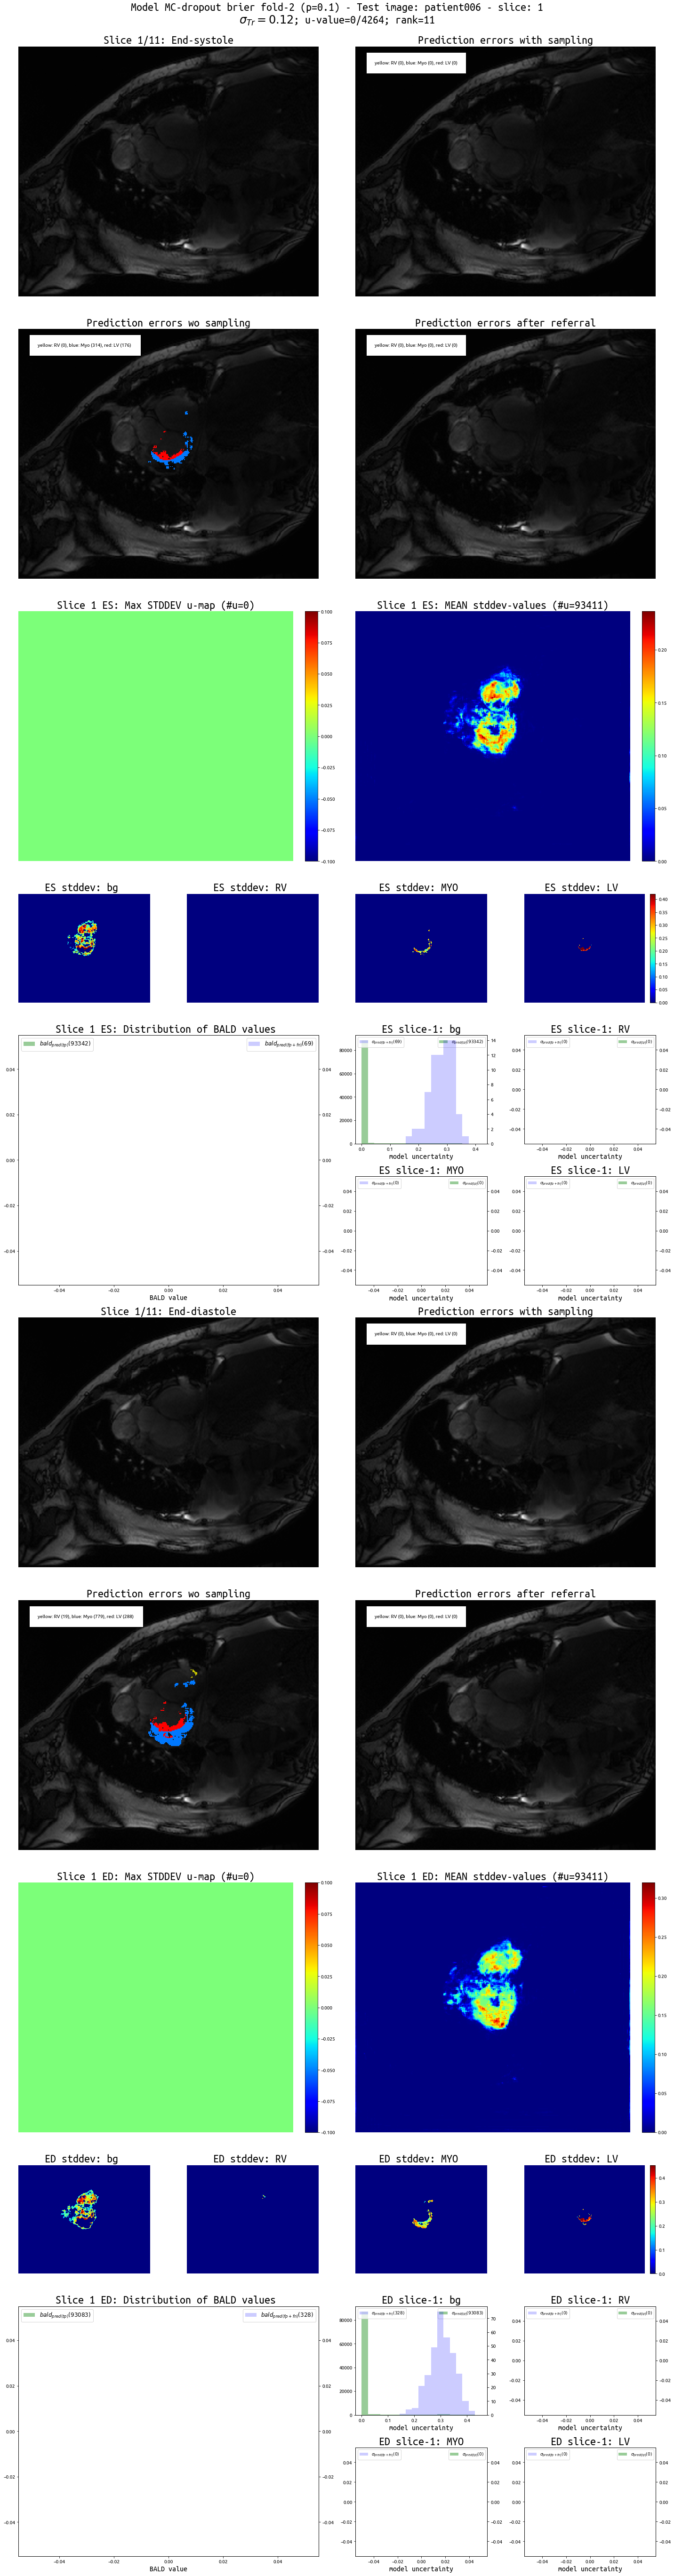

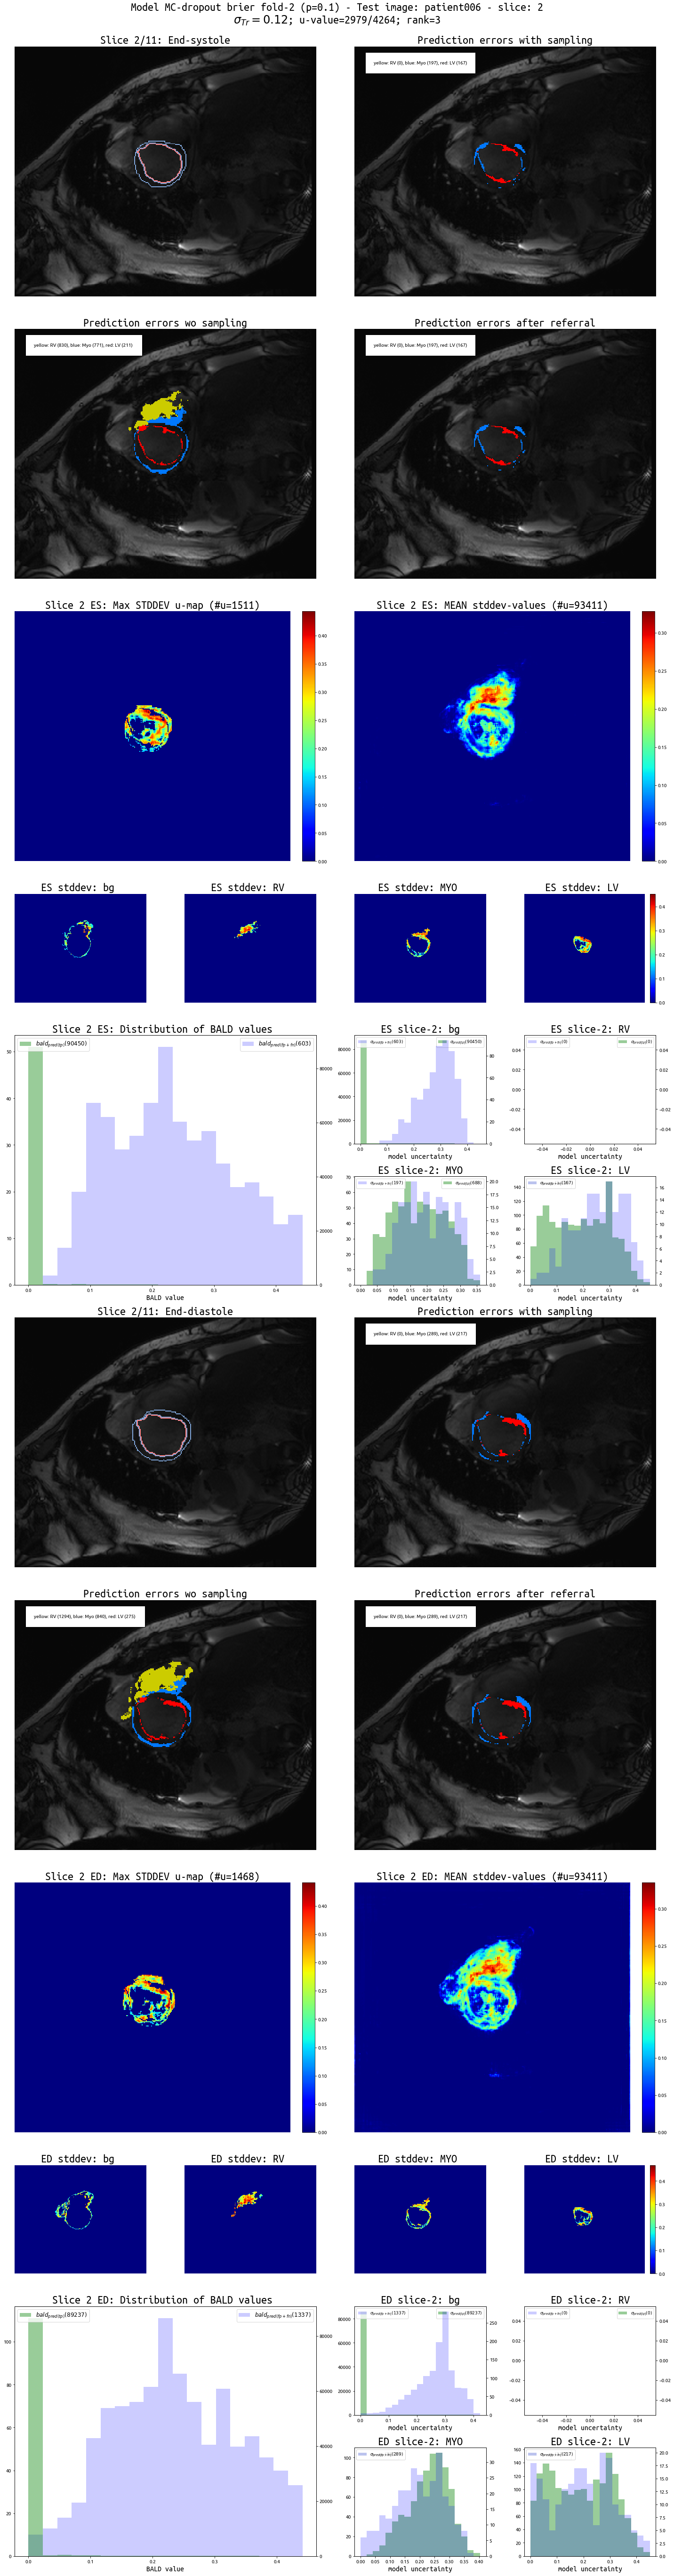

INFO - Ready!


In [34]:
# model_name a) Baseline  b) MC-dropout 0.1

model_name = exper_handler.exper.model_name
errors_only = False  # in case of the BASELINE model we only want the seg-errors
plot_detailed_hists = True
image_range = [0]
if image_range is None:
    image_range = np.arange(len(exper_handler.test_results.image_names))


for image_num in image_range:
    exper_handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                                 info_type="uncertainty",
                                                                 do_save=False, slice_range=[0, 1],
                                                                 std_threshold=0.12, errors_only=errors_only, 
                                                                 do_show=True, use_bald=True,
                                                                 model_name = model_name,
                                                                 plot_detailed_hists=plot_detailed_hists,
                                                                 load_referral=True, ref_positives_only=True)
                                                                 # uncertainty
    print("INFO - Ready!")


going to refer 0 pixels of 1144
U-map max 0.43 & #uncertain-pixels 0


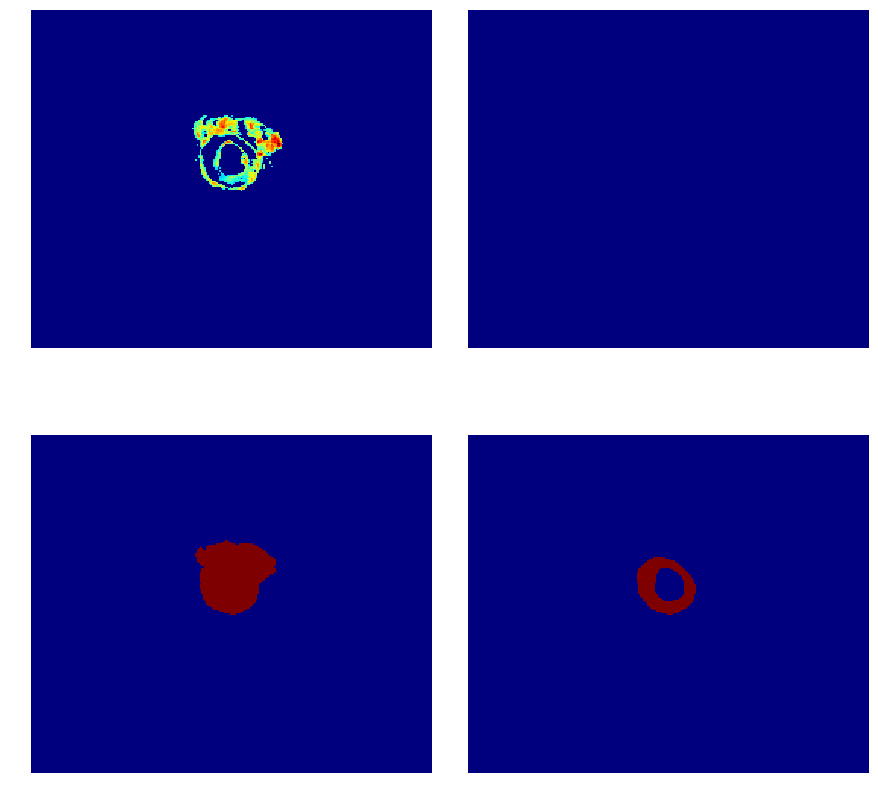

In [42]:
import copy

def create_mask_uncertainties(labels):
    # assuming labels has shape [8classes, width, height, with or without slices]
    num_of_classes = labels.shape[0] / 2
    
    # first flip background labels
    cp_labels = copy.deepcopy(labels)
    for phase in range(2):
        # cls_offset = phase * num_of_classes
        # bg0 = cp_labels[0 + cls_offset] == 0
        # bg1 = cp_labels[0 + cls_offset] == 1
        # print("1. In function ", np.count_nonzero(bg0), np.count_nonzero(bg1))
        # cp_labels[0 + cls_offset][bg0] = 1
        # cp_labels[0 + cls_offset][bg1] = 0

        if phase == 0:
            mask_es = np.sum(cp_labels[1:num_of_classes], axis=0) == 0
        else:
            mask_ed = np.sum(cp_labels[num_of_classes +1:], axis=0) == 0
        
    del cp_labels
    return np.concatenate((np.expand_dims(mask_es, axis=0), np.expand_dims(mask_ed, axis=0))).astype(np.bool)

exper_handler = exper_hdl_mc01_brier
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.u_map_dir))
pred_lbl_input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.pred_lbl_dir))
file_name_lbl = os.path.join(pred_lbl_input_dir, "patient030_pred_labels.npz")

file_name = os.path.join(input_dir, "patient030_filtered_umaps0_14.npz")

file_name_ref_lbl = os.path.join(pred_lbl_input_dir, "patient030_filtered_pred_labels0_14_pos_only.npz")

data = np.load(file_name)
data_lbl = np.load(file_name_lbl)
data_ref_lbl = np.load(file_name_ref_lbl)
u_map = data["filtered_umap"]
u_map_es = u_map[0]
pred_labels = data_lbl["filtered_pred_label"]
ref_lbl_myo = data_ref_lbl["filtered_pred_label"]
# overall_mask = create_mask_uncertainties(pred_labels)
img_slice = 1
# overall_mask_slice_es = overall_mask[0, :, :, img_slice]
u_map_slice = u_map_es[:, :, img_slice]
u_map_slice_pos_only = copy.deepcopy(u_map_slice)

true_labels_slice = copy.deepcopy(exper_handler.test_results.labels[0][1:4, :, :, img_slice])
pred_labels_slice = pred_labels[0:4, :, :, img_slice]
pred_labels_slice_es = np.sum(pred_labels_slice, axis=0)
ref_pred_labels_slice_es = ref_lbl_myo[2, :, :, img_slice]
overall_mask = create_mask_uncertainties(pred_labels_slice)
overall_mask_slice_es = overall_mask[0]
u_map_slice_pos_only[overall_mask_slice_es] = 0
high_unc_pixels = u_map_slice_pos_only != 0

# IMPORTANT HERE
print("going to refer {} pixels of {}".format(np.count_nonzero(high_unc_pixels),
                                              np.count_nonzero(true_labels_slice)))


u_map_max = np.max(u_map_slice)
print("U-map max {:.2f} & #uncertain-pixels {}".format(u_map_max, np.count_nonzero(u_map_slice_pos_only)))
# u_map_slice[u_map_slice < 0.4] = 0
fig = plt.figure(figsize=(15, 15))
ax4plot = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice_pos_only, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(ref_pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")

plt.show()

del u_map
del u_map_es
del u_map_slice

(4, 297, 300)
After max  (297, 300)
U-map max 0.73
595


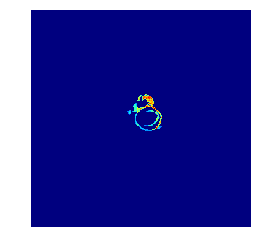

In [58]:
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, config.u_map_dir))
file_name = os.path.join(input_dir, "patient007_filtered_cls_umaps0_14.npz")
data = np.load(file_name)
u_map = data["filtered_cls_umap"]
u_map_es = u_map[:4]
img_slice = 9
u_map_slice = u_map_es[:, :, :, img_slice]
print(u_map_slice.shape)
u_map_slice = np.sum(u_map_slice, axis=0)
print("After max ", u_map_slice.shape)
u_map_max = np.max(u_map_slice)
print("U-map max {:.2f}".format(u_map_max))
print(np.count_nonzero(u_map_slice[u_map_slice >= 0.14]))
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
plt.show()
del u_map
del u_map_es
del u_map_slice

In [69]:
from skimage import data, segmentation
from skimage import exposure
gb_error_codes = [[], (1, 1, 0.), (0., 0.3, 0.7), (1, 0, 0)]

img_es = exper_handler.test_results.images[0][0, :, :, 0]
mask = np.zeros_like(img_es)
rv_lbls = exper_handler.test_results.labels[0][1, :, :, 0]
mask[rv_lbls == 1] = 1
myo_lbls = exper_handler.test_results.labels[0][2, :, :, 0]
mask[myo_lbls == 1] = 2
lv_lbls = exper_handler.test_results.labels[0][3, :, :, 0]
mask[lv_lbls == 1] = 3
img_es = exposure.rescale_intensity(img_es)
clean_border_rv = segmentation.clear_border(rv_lbls).astype(np.int)
clean_border_myo = segmentation.clear_border(myo_lbls).astype(np.int)
clean_border_lv = segmentation.clear_border(lv_lbls).astype(np.int)
img_lbl = segmentation.mark_boundaries(img_es, clean_border_rv, mode="outer", color=gb_error_codes[1], 
                                       background_label=0)
img_lbl = segmentation.mark_boundaries(img_lbl, clean_border_lv, mode="inner", color=gb_error_codes[3], 
                                       background_label=0)
img_lbl = segmentation.mark_boundaries(img_lbl, clean_border_myo, mode="inner", color=gb_error_codes[2], 
                                       background_label=0)
img_lbl = exposure.rescale_intensity(img_lbl, out_range=(0, 1))

(-0.5, 263.5, 222.5, -0.5)

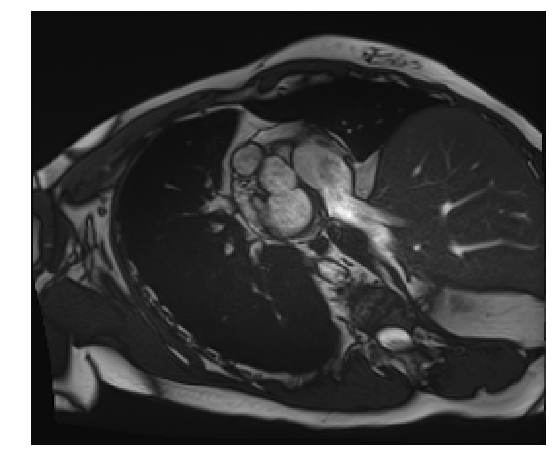

In [70]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=2)
ax1.imshow(img_lbl)
plt.axis('off')

In [11]:
for module in list(dcnn_model.modules()).modules():
    print(module.__repr__)


AttributeError: 'list' object has no attribute 'modules'

In [4]:
checkpoint=20000
exper_handler = exper_hdl_mc01_brier
dcnn_model = exper_handler.load_checkpoint(verbose=False, drop_prob=exper_handler.exper.run_args.drop_prob,
                                               checkpoint=checkpoint)

_ = dcnn_model.eval(mc_dropout=True)

INFO - Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180508_11_47_05_dcnn_mc_f2p01_brier_20KE_lr2e02/checkpoints
INFO - Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180508_11_47_05_dcnn_mc_f2p01_brier_20KE_lr2e02/checkpoints


WARNING MC-DROPOUT - dropout layers are still in training mode
